This [**Jupyter notebook**](http://jupyter.org/) presents an **analysis of cycling counts** along a dedicated cycle lane popular with commuters and recreational cyclists alike ([Tamaki Drive](https://en.wikipedia.org/wiki/Tamaki_Drive), in Auckland central) and examines how **weather conditions** (rainfall, temperature, wind, sunshine fraction) influence the number of cyclists on a day to day basis.   

<!-- TEASER_END -->

It makes use of the [fbprophet](https://facebook.github.io/prophet/) library. **Fbprophet** implements a [Generalized Additive Model](https://en.wikipedia.org/wiki/Generalized_additive_model), and - in a nutshell - models a time-series as the **sum of different components** (non-linear trend, periodic components and holidays or special events) and allows to incorporate **extra-regressors** (categorical or continuous). The reference is [Taylor and Letham, 2017](https://peerj.com/preprints/3190.pdf), see also [this blog post from Facebook research announcing the package](https://research.fb.com/prophet-forecasting-at-scale/).

In this notebook, we first explore some characteristics of the hourly and daily cycling counts over Tamaki drive, then build a model first without, then with the weather extra-regressors. 

The cycling counts data (initially available at the hourly interval) are provided by [Auckland Transport](https://at.govt.nz/) (see [the Auckland Transport cycling and walking research and monitoring website](https://at.govt.nz/cycling-walking/research-monitoring/)) and the hourly weather data are provided by the [National Institute for Water and Atmospheric research](http://www.niwa.co.nz) (NIWA Ltd) [CliFlo](https://cliflo.niwa.co.nz/) database. We used the Mangere Electronic Weather Station (EWS) station in this particular case.   


[Auckland](https://en.wikipedia.org/wiki/Auckland) is the largest city in New Zealand, with a population exceeding 1.5 million people, accounting for more than 1/3 of the country's population. Since 2006, Auckland has also accounted for more than 50% of the country's population growth, adding about 110,000 residents over this period. This has been placing pressure notably on housing and the transportation infrastructure, with congestion being a common occurence during peak hours. [Auckland Transport](https://at.govt.nz/) is the Auckland council-controlled organisation responsible for transport projects and services. Over the past few years it has developed a strategy to actively promote and enable cycling as an alternative to individual automobile, and has built a number of cycle paths across the city. The [Auckland Transport cycling and walking research and monitoring](https://at.govt.nz/cycling-walking/research-monitoring/) department is tasked with conducting research and monitoring on sustainable transportation solutions including cycling and walking. It has installed a total of 39 dedicated cycling (as of June 2018) counters accross the city (see interactive map below). 

### imports and settings 

#### disable the sdout logging of fbprophet 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)

### ignore the pystan DeprecationWarning

In [3]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

In [4]:
import seaborn as sns

In [5]:
sns.set_context('talk')

In [6]:
%matplotlib inline

In [7]:
import os
import sys
from glob import glob 

In [8]:
import numpy as np

In [9]:
np.random.seed(42)

In [10]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

### folium for interactive mapping of the counters location

In [11]:
import folium
from folium.plugins import MarkerCluster

### some metrics and stats

In [12]:
from sklearn.metrics import mean_absolute_error as MAE
from scipy.stats import skew

### some utilities from the calendar package 

In [13]:
from calendar import day_abbr, month_abbr, mdays

#### we use the convenient [holiday package](https://github.com/dr-prodigy/python-holidays) from [Maurizio Montel](https://github.com/dr-prodigy) to build a DataFrame of national and regional (Auckland region) holidays

In [14]:
import holidays

#### fbprophet itself, we use here the version 0.3, release on the 3rd of June 2018

In [15]:
import fbprophet

In [16]:
fbprophet.__version__

'0.7.1'

In [17]:
Prophet = fbprophet.Prophet

### import some utility functions for data munging and plotting 

In [18]:
sys.path.append('../code/')

In [19]:
import utils

### reads the counter locations 

we read the counters locations, and display these locations on an interactive map powered by [Folium]()

In [20]:
loc_counters = pd.read_csv('../data/cycling_Auckland/cycling_counters.csv')

In [21]:
loc_counters = loc_counters.query("user_type == 'Cyclists'")

In [22]:
len(loc_counters)

39

In [23]:
loc_counters.loc[loc_counters.name.str.contains("Tamaki"),:]

name         id           Name.1   latitude  longitude  \
44  Tamaki Drive EB  100000827  Tamaki Drive EB -36.847782  174.78935   
45  Tamaki Drive WB  100003810  Tamaki Drive WB -36.847942  174.78903   

      site_code  setup_date user_type  
44  ECO08011685  12/11/2009  Cyclists  
45  U15G2011813  26/03/2012  Cyclists

In [24]:
center_lat = loc_counters.query("name == 'Tamaki Drive EB'").latitude.values[0]
center_lon = loc_counters.query("name == 'Tamaki Drive EB'").longitude.values[0]

In [25]:
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=14,
    tiles='OpenStreetMap', 
    width='80%', 
)

m.add_child(folium.LatLngPopup())

# marker_cluster = MarkerCluster().add_to(m)

for i, row in loc_counters.iterrows():
    name = row['name']
    lat = row.latitude
    lon = row.longitude
    opened = row.setup_date
    
    # HTML here in the pop up 
    popup = '<b>{}</b></br><i>setup date = {}</i>'.format(name, opened)
    
    folium.Marker([lat, lon], popup=popup, tooltip=name).add_to(m)

In [26]:
m

### read the actual counter data, and extract the time-series for the Tamaki drive counters 

In [27]:
lfiles = glob('../data/cycling_Auckland/cycling_counts_????.csv')

In [28]:
lfiles.sort()

In [29]:
lfiles

['../data/cycling_Auckland/cycling_counts_2010.csv',
 '../data/cycling_Auckland/cycling_counts_2011.csv',
 '../data/cycling_Auckland/cycling_counts_2012.csv',
 '../data/cycling_Auckland/cycling_counts_2013.csv',
 '../data/cycling_Auckland/cycling_counts_2014.csv',
 '../data/cycling_Auckland/cycling_counts_2015.csv',
 '../data/cycling_Auckland/cycling_counts_2016.csv',
 '../data/cycling_Auckland/cycling_counts_2017.csv',
 '../data/cycling_Auckland/cycling_counts_2018.csv']

In [30]:
l = []
for f in lfiles: 
    d = pd.read_csv(f, index_col=0, parse_dates=True)
    l.append(d)

In [31]:
df = pd.concat(l, axis=0)

In [32]:
df = df.loc[:,['Tamaki Drive EB', 'Tamaki Drive WB']]

In [33]:
df.head()

Tamaki Drive EB  Tamaki Drive WB
datetime                                             
2010-07-01 00:00:00              2.0              NaN
2010-07-01 01:00:00              3.0              NaN
2010-07-01 02:00:00              1.0              NaN
2010-07-01 03:00:00              1.0              NaN
2010-07-01 04:00:00              2.0              NaN

In [34]:
df.between_time('06:00','21:00').sum(1).mean()

61.442219776498476

In [35]:
df.dropna().sum()

Tamaki Drive EB    1613428.0
Tamaki Drive WB    1015577.0
dtype: float64

### adds Tamaki drive eastern bound and western bound together 

In [36]:
Tamaki = df.loc[:,'Tamaki Drive WB'] +  df.loc[:,'Tamaki Drive EB']

In [37]:
Tamaki = Tamaki.to_frame(name='Tamaki Drive')

### restrict to the period where the hourly weather data is available 

In [38]:
Tamaki = Tamaki.loc['2013':'2018-06-01',]

there seems to be a few pretty large outliers, we're going to try and filter these out

<AxesSubplot:xlabel='datetime'>

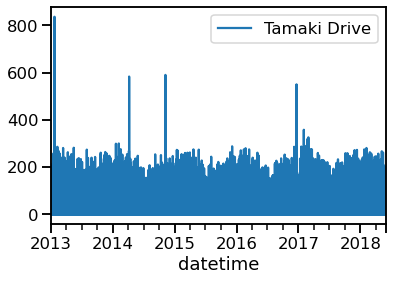

In [39]:
Tamaki.plot()

### getting rid of the outliers using a median filter 

In [40]:
dfc = Tamaki.copy()

In [41]:
dfc.loc[:,'Tamaki Drive, Filtered'] = utils.median_filter(dfc, varname='Tamaki Drive')

<AxesSubplot:xlabel='datetime'>

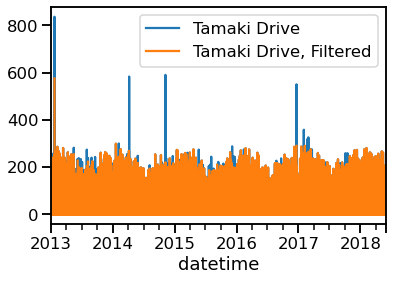

In [42]:
dfc.plot()

In [43]:
dfc.isnull().sum()

Tamaki Drive                6
Tamaki Drive, Filtered    229
dtype: int64

### plots the seasonal cycle (average and inter-quartile range)

In [44]:
seas_cycl = dfc.loc[:,'Tamaki Drive'].rolling(window=30*24, center=True, min_periods=20).mean().groupby(dfc.index.dayofyear).mean()

In [45]:
q25 = dfc.loc[:,'Tamaki Drive'].rolling(window=30*24, center=True, min_periods=20).mean().groupby(dfc.index.dayofyear).quantile(0.25)
q75 = dfc.loc[:,'Tamaki Drive'].rolling(window=30*24, center=True, min_periods=20).mean().groupby(dfc.index.dayofyear).quantile(0.75)

the following cells build the ticks and tick labels for the seasonal cycle plot 

In [46]:
ndays_m = mdays.copy()

In [47]:
ndays_m[2] = 29

In [48]:
ndays_m = np.cumsum(ndays_m)

In [49]:
month_abbr = month_abbr[1:]

Text(0.5, 1.0, 'Tamaki Drive: 30 days running average hourly cycling counts')

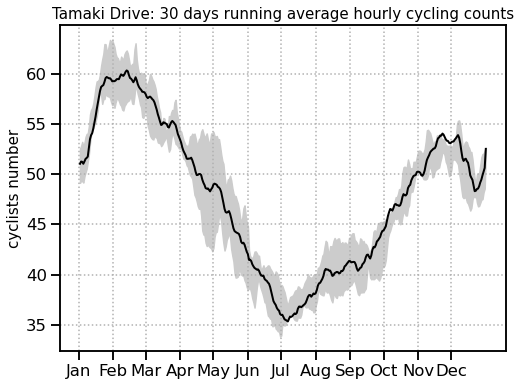

In [50]:
f, ax = plt.subplots(figsize=(8,6)) 

seas_cycl.plot(ax=ax, lw=2, color='k', legend=False)

ax.fill_between(seas_cycl.index, q25.values.ravel(), q75.values.ravel(), color='0.8')

ax.set_xticks(ndays_m[:-1])
ax.set_xticklabels(month_abbr)

ax.grid(ls=':')

ax.set_xlabel('', fontsize=15)

ax.set_ylabel('cyclists number', fontsize=15);

# [l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
# [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_title('Tamaki Drive: 30 days running average hourly cycling counts', fontsize=15)

# for ext in ['png','jpeg','pdf']: 
#     f.savefig(f'../figures/paper/seasonal_cycle.{ext}', dpi=200)

### cyclists per day of week and hour of the day 

In [51]:
hour_week = Tamaki.loc[:,['Tamaki Drive']].copy()

In [52]:
hour_week.loc[:,'day_of_week'] = hour_week.index.dayofweek
hour_week.loc[:,'hour'] = hour_week.index.hour

In [53]:
hour_week = hour_week.groupby(['day_of_week','hour']).mean().unstack()

In [54]:
hour_week.columns = hour_week.columns.droplevel(0)

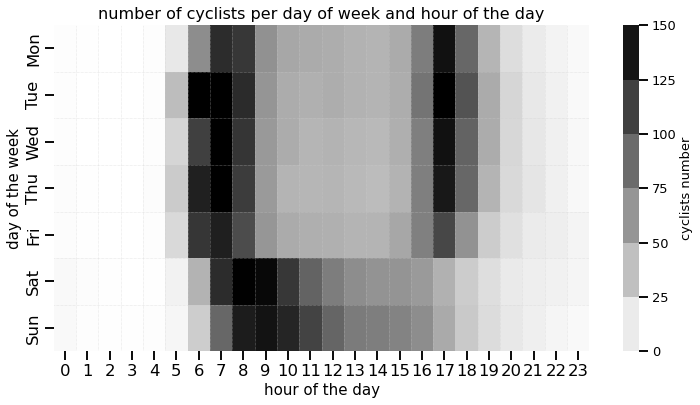

In [55]:
f, ax = plt.subplots(figsize=(12,6))

sns.heatmap(hour_week, ax = ax, cmap=plt.cm.gray_r, vmax=150, cbar_kws={'boundaries':np.arange(0,160,25)})

cbax = f.axes[1]
[l.set_fontsize(13) for l in cbax.yaxis.get_ticklabels()]
cbax.set_ylabel('cyclists number', fontsize=13)

[ax.axhline(x, ls=':', lw=0.5, color='0.8') for x in np.arange(1, 7)]
[ax.axvline(x, ls=':', lw=0.5, color='0.8') for x in np.arange(1, 24)];

ax.set_title('number of cyclists per day of week and hour of the day', fontsize=16)

# [l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
# [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('hour of the day', fontsize=15)
ax.set_ylabel('day of the week', fontsize=15)
ax.set_yticklabels(day_abbr[0:7]);

# for ext in ['png','jpeg','pdf']: 
#     f.savefig(f'../figures/paper/cyclists_dayofweek_hourofday.{ext}', dpi=200)

### looking at week days versus week-ends 

In [56]:
Tamaki.index.weekday

Int64Index([1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            ...
            4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
           dtype='int64', name='datetime', length=47472)

In [57]:
Tamaki.index.day_of_week

Int64Index([1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            ...
            4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
           dtype='int64', name='datetime', length=47472)

In [58]:
weekdays = dfc.loc[Tamaki.index.weekday.isin(list(range(5))), 'Tamaki Drive, Filtered']
weekends = dfc.loc[dfc.index.weekday.isin([5,6]), 'Tamaki Drive, Filtered']

In [59]:
summary_hour_weekdays = weekdays.groupby(weekdays.index.hour).describe()
summary_hour_weekends = weekends.groupby(weekends.index.hour).describe()

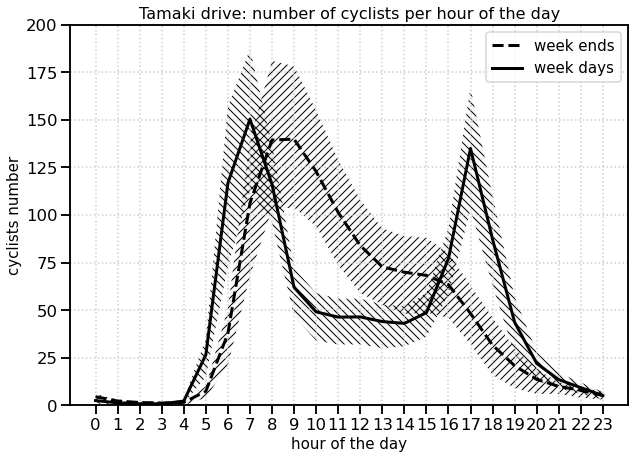

In [60]:
f, ax = plt.subplots(figsize=(10,7))

ax.plot(summary_hour_weekends.index, summary_hour_weekends.loc[:,'mean'], color='k', label='week ends', ls='--', lw=3)

ax.fill_between(summary_hour_weekends.index, summary_hour_weekends.loc[:,'25%'], \
                summary_hour_weekends.loc[:,'75%'], hatch='///', facecolor='0.8', alpha=0.1)

ax.set_xticks(range(24));

ax.grid(ls=':', color='0.8')

# ax.set_title('week-ends', fontsize=16)

ax.plot(summary_hour_weekdays.index, summary_hour_weekdays.loc[:,'mean'], color='k', label='week days', lw=3)

ax.fill_between(summary_hour_weekdays.index, summary_hour_weekdays.loc[:,'25%'], \
                summary_hour_weekdays.loc[:,'75%'], hatch='\\\\\\', facecolor='0.8', alpha=0.1)

ax.legend(loc=1 , fontsize=15)

ax.set_xticks(range(24));

ax.grid(ls=':', color='0.8')

ax.set_ylim([0, 200])

ax.set_xlabel('hour of the day', fontsize=15)

ax.set_ylabel('cyclists number', fontsize=15);

# [l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
# [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_title('Tamaki drive: number of cyclists per hour of the day', fontsize=16)

for ext in ['png','jpeg','pdf']: 
    f.savefig(f'../figures/paper/daily_cycle.{ext}', dpi=200)

### calculates the daily totals from the hourly data 

In [61]:
data = dfc.loc['2013':,['Tamaki Drive, Filtered']].resample('1D').sum()

### plots the time series 

We are separating the time-series into a **training set** (the period 2013 to 2016 included, i.e. 1461 days) and a **test set** (the period ranging from the 1st January 2017 to the 1st of June 2018, i.e. 517 days). The model will be fitted on the training set, and evaluated on the test set (out of sample prediction), to ensure a fair evaluation of the performance of the model. The grey vertical bar on the figure below marks the separation between the training and test set. 

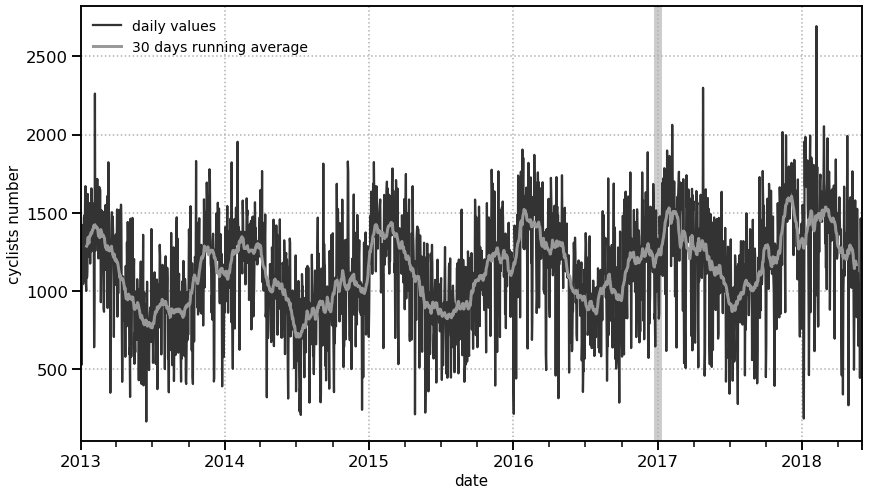

In [62]:
f, ax = plt.subplots(figsize=(14,8))

data.plot(ax=ax, color='0.2')

data.rolling(window=30, center=True).mean().plot(ax=ax, ls='-', lw=3, color='0.6')

ax.grid(ls=':')
ax.legend(['daily values','30 days running average'], frameon=False, fontsize=14)

# [l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
# [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('date', fontsize=15)

ax.set_ylabel('cyclists number', fontsize=15);

ax.axvline('2017', color='0.8', lw=8, zorder=-1)

for ext in ['png','jpeg','pdf']: 
    f.savefig(f'../figures/paper/cycling_counts_Tamaki_drive.{ext}', dpi=200)

### creates a pandas dataframe holding the dates of the holidays (both national holidays and the Auckland regions' specific holidays)

see [holiday](https://github.com/dr-prodigy/python-holidays)

In [63]:
holidays_df = pd.DataFrame([], columns = ['ds','holiday'])

In [64]:
ldates = []
lnames = []
for date, name in sorted(holidays.NZ(prov='AUK', years=np.arange(2013, 2018 + 1)).items()):
    ldates.append(date)
    lnames.append(name)

In [65]:
ldates = np.array(ldates)
lnames = np.array(lnames)

In [66]:
holidays_df.loc[:,'ds'] = ldates

In [67]:
holidays_df.loc[:,'holiday'] = lnames

In [68]:
holidays_df.holiday.unique()

array(["New Year's Day", "Day after New Year's Day",
       'Auckland Anniversary Day', 'Waitangi Day', 'Good Friday',
       'Easter Monday', 'Anzac Day', "Queen's Birthday", 'Labour Day',
       'Christmas Day', 'Boxing Day', 'Anzac Day (Observed)',
       'Boxing Day (Observed)', "Day after New Year's Day (Observed)",
       'Waitangi Day (Observed)', 'Christmas Day (Observed)',
       "New Year's Day (Observed)"], dtype=object)

we conflate the actual holidays and the 'observed' ones to reduce the number of categories

In [69]:
holidays_df.loc[:,'holiday'] = holidays_df.loc[:,'holiday'].apply(lambda x : x.replace(' (Observed)',''))

In [70]:
holidays_df.holiday.unique()

array(["New Year's Day", "Day after New Year's Day",
       'Auckland Anniversary Day', 'Waitangi Day', 'Good Friday',
       'Easter Monday', 'Anzac Day', "Queen's Birthday", 'Labour Day',
       'Christmas Day', 'Boxing Day'], dtype=object)

### prepares the cycling count ndata for ingesting in fbprophet

In [71]:
data = data.rename({'Tamaki Drive, Filtered':'y'}, axis=1)

In [72]:
data.head()

y
datetime          
2013-01-01  1163.0
2013-01-02  1112.0
2013-01-03   527.0
2013-01-04  1045.0
2013-01-05  1422.0

### Splits the data into a training and test set, and returns these data frames in a format **fbprophet** can understand 

In [73]:
data_train, data_test = utils.prepare_data(data, 2017)

In [74]:
data_train.tail()

ds       y
1456 2016-12-27  1515.0
1457 2016-12-28   998.0
1458 2016-12-29   999.0
1459 2016-12-30  1333.0
1460 2016-12-31  1239.0

In [75]:
data_test.head()

ds       y
0 2017-01-01  1245.0
1 2017-01-02   956.0
2 2017-01-03   823.0
3 2017-01-04   853.0
4 2017-01-05  1476.0

### Instantiate, then fit the model to the training data 

The first step in **fbprophet** is to instantiate the model, it is there that you can set the `prior scales` for each component of your time-series, as well as the number of Fourier series to use to model the cyclic components.   

A general rule is that larger prior scales and larger number of Fourier series will make the model more flexible, but at the potential cost of generalisation: i.e. the model might [overfit](https://en.wikipedia.org/wiki/Overfitting), learning the noise (rather than the signal) in the training data, but 
    giving poor results when applied to yet unseen data (the test data)... setting these [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)) can be more an art than a science ... 

In [76]:
m = Prophet(mcmc_samples=300, holidays=holidays_df, holidays_prior_scale=0.25, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)

In [ ]:
m.fit(data_train)

### make the `future` dataframe 

In [78]:
future = m.make_future_dataframe(periods=len(data_test), freq='1D')

In [79]:
future.head()

ds
0 2013-01-01
1 2013-01-02
2 2013-01-03
3 2013-01-04
4 2013-01-05

In [80]:
future.tail()

ds
1973 2018-05-28
1974 2018-05-29
1975 2018-05-30
1976 2018-05-31
1977 2018-06-01

### forecast

In [81]:
forecast = m.predict(future)

### plots the `components` of the forecast (trend + cyclic component [yearly seasonality, weekly seasonality] and effects of the holidays at this stage)

/home/nicolasf/mambaforge/envs/blog/lib/python3.7/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/home/nicolasf/mambaforge/envs/blog/lib/python3.7/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/home/nicolasf/mambaforge/envs/blog/lib/python3.7/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


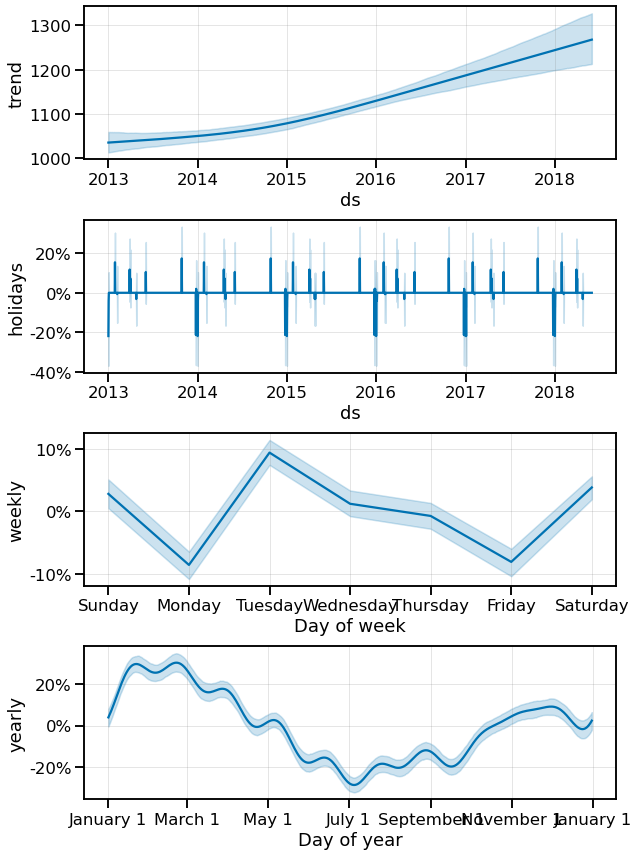

In [82]:
f = m.plot_components(forecast)

### put it all together with the actual observations 

In [83]:
verif = utils.make_verif(forecast, data_train, data_test)

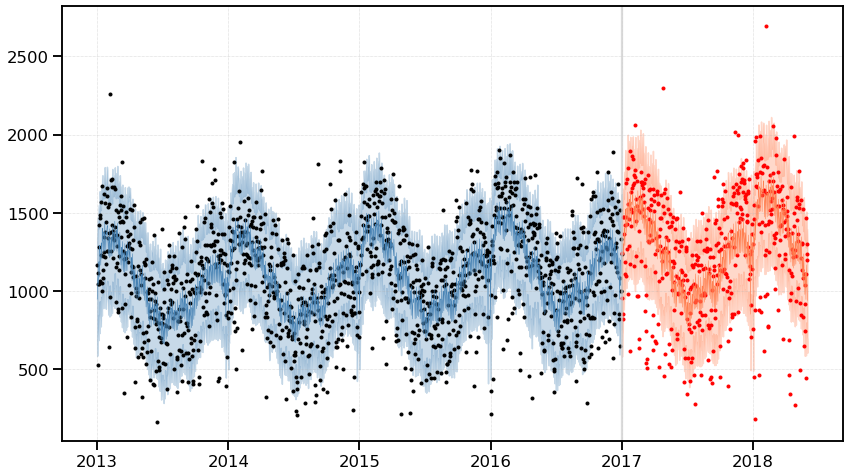

In [85]:
f = utils.plot_verif(verif)

### scatter plot, marginal distribution and correlation between observations and modelled / predicted values 

#### train set 

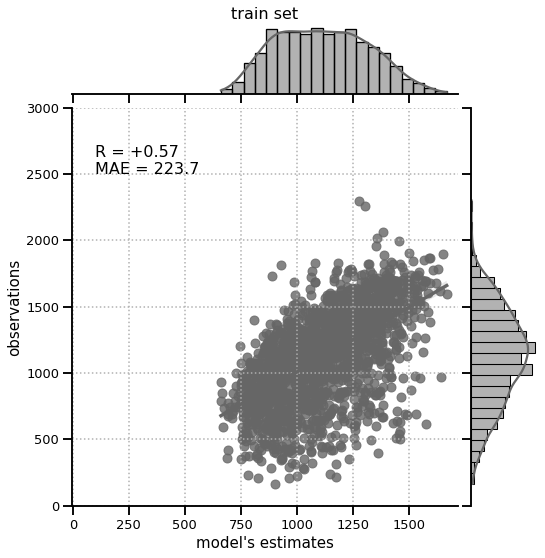

In [86]:
utils.plot_joint_plot(verif.loc[:'2017',:], title='train set', fname='train_set_joint_plot_no_climate')

### test set 

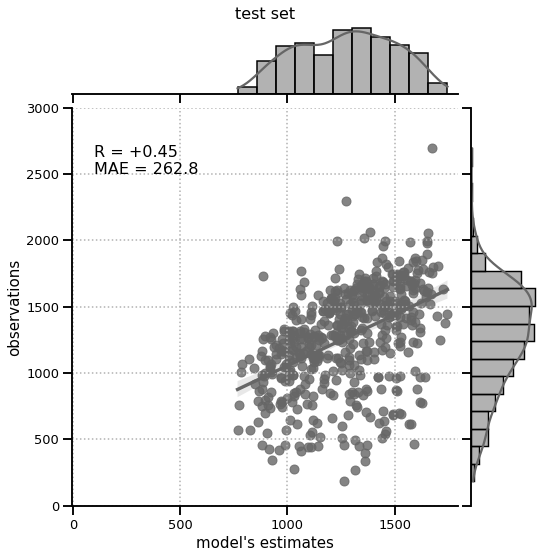

In [87]:
utils.plot_joint_plot(verif.loc['2017':,:], title='test set', fname='test_set_joint_plot_no_climate')

In [88]:
verif.loc['2017':,['y','yhat']].corr()

y      yhat
y     1.000000  0.453769
yhat  0.453769  1.000000

### Mean Absolute Error (in number of cyclists)

In [89]:
MAE(verif.loc['2017':,'y'].values, verif.loc['2017':,'yhat'].values)

262.7671376097647

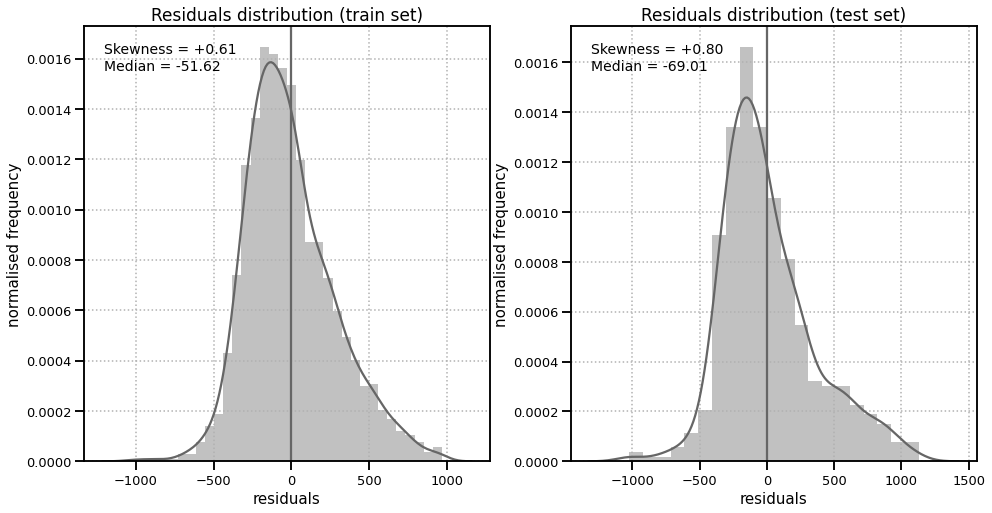

In [90]:
f, axes = plt.subplots(ncols = 2, figsize=(16,8))

ax = axes[0]

sns.distplot((verif.loc[:'2017','yhat'] - verif.loc[:'2017','y']), ax=ax, color='0.4')
ax.grid(ls=':')
ax.set_xlabel('residuals', fontsize=15)
ax.set_ylabel("normalised frequency", fontsize=15)
ax.grid(ls=':')

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

skewness = skew(verif.loc[:'2017','yhat'] - verif.loc[:'2017','y'])
medianres = (verif.loc[:'2017','yhat'] - verif.loc[:'2017','y']).median()

ax.text(0.05, 0.9, "Skewness = {:+4.2f}\nMedian = {:+4.2f}".\
        format(skewness, medianres), \
        fontsize=14, transform=ax.transAxes)

ax.axvline(0, color='0.4')

ax.set_title('Residuals distribution (train set)', fontsize=17)

ax = axes[1]
sns.distplot((verif.loc['2017':,'yhat'] - verif.loc['2017':,'y']), ax=ax, color='0.4')
ax.grid(ls=':')
ax.set_xlabel('residuals', fontsize=15)
ax.set_ylabel("normalised frequency", fontsize=15)
ax.grid(ls=':')

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

ax.text(0.05, 0.9, "Skewness = {:+4.2f}\nMedian = {:+4.2f}".\
        format(skew(verif.loc['2017':,'yhat'] - verif.loc['2017':,'y']), (verif.loc['2017':,'yhat'] - verif.loc['2017':,'y']).median()), \
        fontsize=14, transform=ax.transAxes)

ax.axvline(0, color='0.4')

ax.set_title('Residuals distribution (test set)', fontsize=17)

for ext in ['png','jpeg','pdf']: 
    f.savefig(f'../figures/paper/residuals_distribution_train_test_set_no_climate.{ext}', dpi=200)

## incorporating the effects of weather conditions

Now we add daytime (i.e. 6 AM to 9 PM) averaged temperature, rainfall, sunshine fraction and windspeed as **extra regressors** in the fbprophet model 

#### temperature 

In [91]:
temp = pd.read_csv('../data/weather/hourly/commute/temp_day.csv', index_col=0, parse_dates=True)

In [92]:
temp = temp.loc[:,['Tmin(C)']]

In [93]:
temp.columns = ['temp']

In [94]:
temp.head()

temp
2012-01-01  19.807143
2012-01-02  18.000000
2012-01-03  19.335714
2012-01-04  19.307143
2012-01-05  19.978571

#### rainfall 

In [95]:
rain = pd.read_csv('../data/weather/hourly/commute/rain_day.csv', index_col=0, parse_dates=True)

In [96]:
rain = rain.loc[:,['Amount(mm)']]

In [97]:
rain.columns = ['rain']

In [98]:
rain.head()

rain
2012-01-01  0.000000
2012-01-02  0.000000
2012-01-03  0.028571
2012-01-04  0.185714
2012-01-05  0.014286

#### sunshine fraction 

In [99]:
sun = pd.read_csv('../data/weather/hourly/commute/sun_day.csv', index_col=0, parse_dates=True)

In [100]:
sun.columns = ['sun']

In [101]:
sun.head()

sun
2012-01-01  0.078571
2012-01-02  0.128571
2012-01-03  0.321429
2012-01-04  0.128571
2012-01-05  0.378571

#### wind 

In [102]:
wind = pd.read_csv('../data/weather/hourly/commute/wind_day.csv', index_col=0, parse_dates=True)

In [103]:
wind = wind.loc[:,['Speed(m/s)']]

In [104]:
wind.columns = ['wind']

In [105]:
wind.head()

wind
2011-01-01  8.464286
2011-01-02  3.857143
2011-01-03  3.871429
2011-01-04  2.392857
2011-01-05  6.621429

### restrict to the available period 

In [106]:
temp = temp.loc['2013':'2018-06-01',:]

In [107]:
rain = rain.loc['2013':'2018-06-01',:]

In [108]:
sun = sun.loc['2013':'2018-06-01',:]

In [109]:
wind = wind.loc['2013':'2018-06-01',:]

### interpolate so that there are no missing values 

In [110]:
temp = temp.interpolate(method='linear')

In [111]:
rain = rain.interpolate(method='linear')

In [112]:
sun = sun.interpolate(method='linear')

In [113]:
wind = wind.interpolate(method='linear')

In [114]:
temprm = temp.rolling(window=3, min_periods=3).mean()

In [115]:
temprm.columns = ['temprm']

In [116]:
rainrm = rain.rolling(window=3, min_periods=3).sum()

In [117]:
rainrm.columns = ['rainrm']

In [118]:
sunrm = sun.rolling(window=3, min_periods=3).mean()

In [119]:
sunrm.columns  = ['sunrm']

In [120]:
windrm = wind.rolling(window=3, min_periods=3).mean()

In [121]:
windrm.columns  = ['windrm']

### adds the climate regressors to the data 

In [122]:
data_with_regressors = utils.add_regressor(data, temp, varname='temp')

In [123]:
data_with_regressors = utils.add_regressor(data_with_regressors, rain, varname='rain')

In [124]:
data_with_regressors = utils.add_regressor(data_with_regressors, sun, varname='sun')

In [125]:
data_with_regressors = utils.add_regressor(data_with_regressors, wind, varname='wind')

In [126]:
data_with_regressors.head()

y       temp      rain       sun      wind
datetime                                                   
2013-01-01  1163.0  20.000000  0.000000  0.950000  6.100000
2013-01-02  1112.0  20.342857  0.000000  0.535714  4.428571
2013-01-03   527.0  16.278571  0.228571  0.014286  4.728571
2013-01-04  1045.0  17.635714  0.000000  0.742857  8.978571
2013-01-05  1422.0  19.592857  0.000000  0.964286  6.185714

In [127]:
data_with_regressors.tail()

y      temp  rain       sun      wind
datetime                                              
2018-05-28  1107.0  8.750000   0.0  0.271429  3.200000
2018-05-29  1464.0  7.764286   0.0  0.671429  2.571429
2018-05-30  1298.0  7.614286   0.0  0.621429  2.378571
2018-05-31  1239.0  8.192857   0.0  0.678571  2.057143
2018-06-01  1196.0  9.085714   0.0  0.635714  2.178571

### prepare the data and subsets (train and test set)

In [128]:
data_train, data_test = utils.prepare_data(data_with_regressors, 2017)

### we first instantiates a new fbprophet model, using the exact same prior scales and parameters as before 

In [129]:
m = Prophet(mcmc_samples=300, holidays=holidays_df, holidays_prior_scale=0.25, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)

Then we add the **extra-regressors** to the model using the `add_regressor` method

In [130]:
m.add_regressor('temp', prior_scale=0.5, mode='multiplicative')
m.add_regressor('rain', prior_scale=0.5, mode='multiplicative')
m.add_regressor('sun', prior_scale=0.5, mode='multiplicative')
m.add_regressor('wind', prior_scale=0.5, mode='multiplicative')

fit the new model

In [ ]:
m.fit(data_train)

make the future DataFrame

In [132]:
future = m.make_future_dataframe(periods=len(data_test), freq='1D')

add the extra-regressors observed over the `future` DataFrame period 

In [133]:
futures = utils.add_regressor_to_future(future, [temp, rain, sun, wind])

In [133]:
futures = utils.add_regressor_to_future(future, [temp, rain, sun, wind])

In [134]:
futures.head()

ds       temp      rain       sun      wind
0 2013-01-01  20.000000  0.000000  0.950000  6.100000
1 2013-01-02  20.342857  0.000000  0.535714  4.428571
2 2013-01-03  16.278571  0.228571  0.014286  4.728571
3 2013-01-04  17.635714  0.000000  0.742857  8.978571
4 2013-01-05  19.592857  0.000000  0.964286  6.185714

In [134]:
futures.head()

ds       temp      rain       sun      wind
0 2013-01-01  20.000000  0.000000  0.950000  6.100000
1 2013-01-02  20.342857  0.000000  0.535714  4.428571
2 2013-01-03  16.278571  0.228571  0.014286  4.728571
3 2013-01-04  17.635714  0.000000  0.742857  8.978571
4 2013-01-05  19.592857  0.000000  0.964286  6.185714

In [135]:
forecast = m.predict(futures)

In [135]:
forecast = m.predict(futures)

/home/nicolasf/mambaforge/envs/blog/lib/python3.7/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/home/nicolasf/mambaforge/envs/blog/lib/python3.7/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/home/nicolasf/mambaforge/envs/blog/lib/python3.7/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/home/nicolasf/mambaforge/envs/blog/lib/python3.7/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


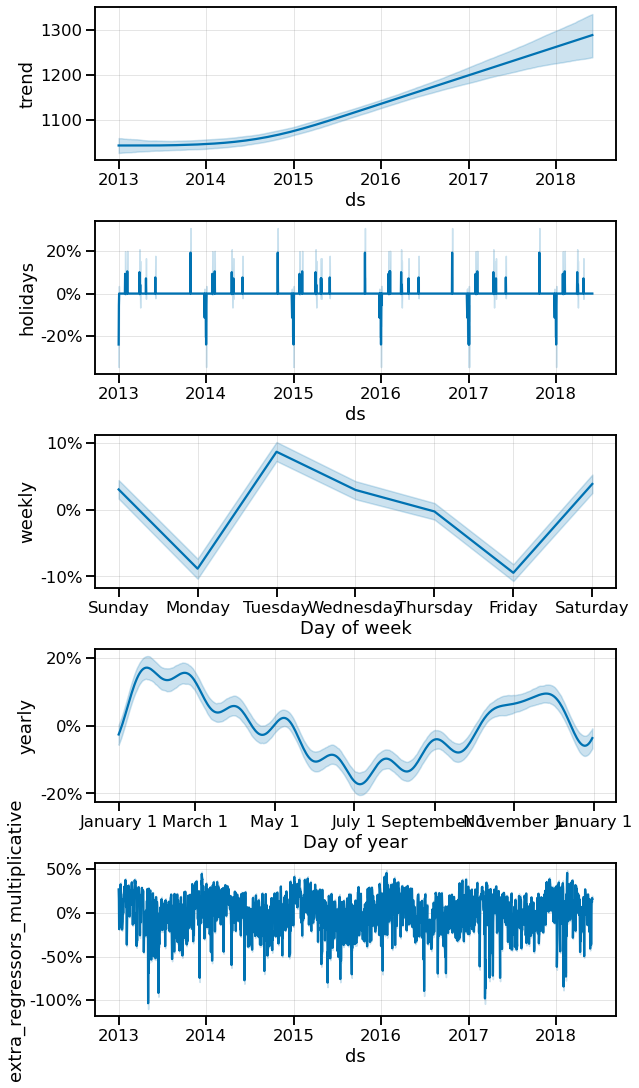

In [136]:
f = m.plot_components(forecast)

In [137]:
verif = utils.make_verif(forecast, data_train, data_test)

In [137]:
verif = utils.make_verif(forecast, data_train, data_test)

In [138]:
verif.head()

ds        trend   yhat_lower   yhat_upper  trend_lower  \
ds                                                                          
2013-01-01 2013-01-01  1042.746577   863.011328  1373.897051  1025.967755   
2013-01-02 2013-01-02  1042.746122   915.772937  1401.574525  1026.077492   
2013-01-03 2013-01-03  1042.745667   607.903976  1070.742596  1026.168166   
2013-01-04 2013-01-04  1042.745211   747.778337  1189.432078  1026.223438   
2013-01-05 2013-01-05  1042.744756  1132.222583  1619.312709  1026.278710   

            trend_upper  Anzac Day  Anzac Day_lower  Anzac Day_upper  \
ds                                                                     
2013-01-01  1059.229810        0.0              0.0              0.0   
2013-01-02  1059.206679        0.0              0.0              0.0   
2013-01-03  1059.108495        0.0              0.0              0.0   
2013-01-04  1059.009228        0.0              0.0              0.0   
2013-01-05  1058.909960        0.0              0.0              0.0   

            Auckland Anniversary Day  ...  wind_lower  wind_upper    yearly  \
ds                                    ...                                     
2013-01-01                       0.0  ...   -0.046613   -0.041496 -0.026108   
2013-01-02                       0.0  ...    0.023622    0.026535 -0.016320   
2013-01-03                       0.0  ...    0.011934    0.013406 -0.005556   
2013-01-04                       0.0  ...   -0.172589   -0.153643  0.006038   
2013-01-05                       0.0  ...   -0.050364   -0.044835  0.018303   

            yearly_lower  yearly_upper  additive_terms  additive_terms_lower  \
ds                                                                             
2013-01-01     -0.056458      0.002167             0.0                   0.0   
2013-01-02     -0.046299      0.012371             0.0                   0.0   
2013-01-03     -0.035939      0.022092             0.0                   0.0   
2013-01-04     -0.023675      0.033736             0.0                   0.0   
2013-01-05     -0.010998      0.046270             0.0                   0.0   

            additive_terms_upper         yhat       y  
ds                                                     
2013-01-01                   0.0  1129.417535  1163.0  
2013-01-02                   0.0  1160.871519  1112.0  
2013-01-03                   0.0   838.160277   527.0  
2013-01-04                   0.0   975.812949  1045.0  
2013-01-05                   0.0  1374.738820  1422.0  

[5 rows x 71 columns]

In [139]:
verif.loc[:,'yhat'] = verif.yhat.clip(lower=0)

In [139]:
verif.loc[:,'yhat'] = verif.yhat.clip(lower=0)

In [140]:
verif.loc[:,'yhat_lower'] = verif.yhat_lower.clip(lower=0)

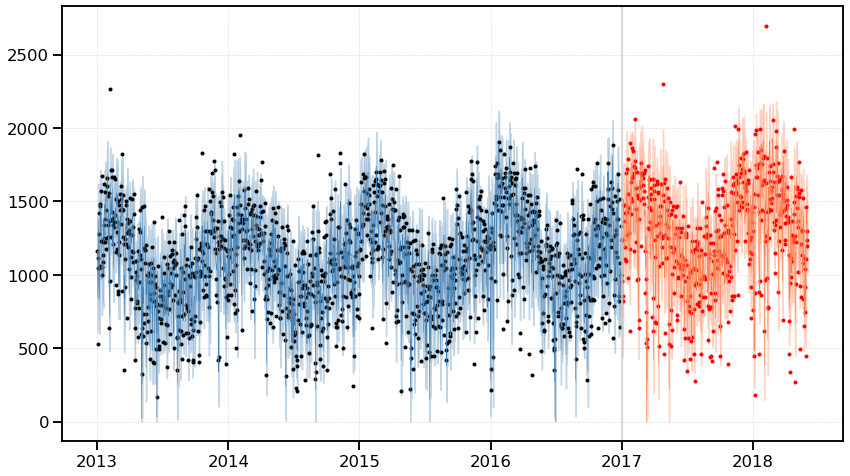

In [141]:
f =  utils.plot_verif(verif)

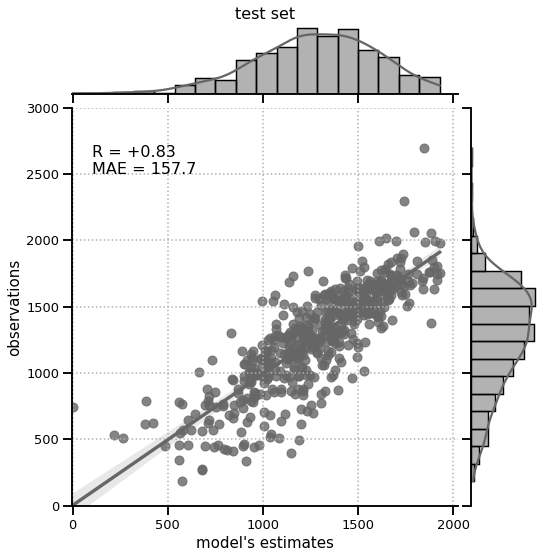

In [142]:
utils.plot_joint_plot(verif.loc['2017':,:], title='test set')

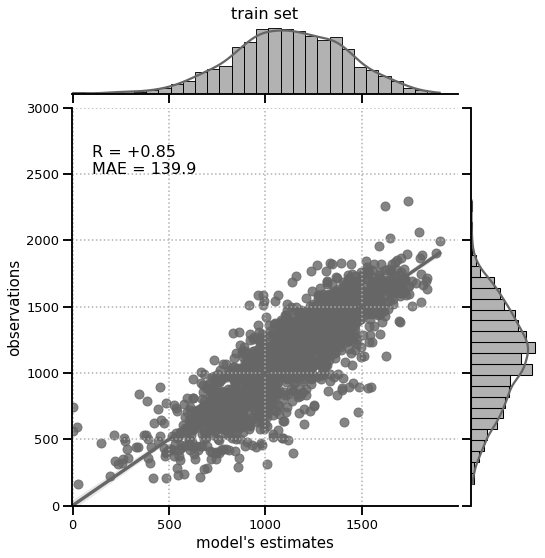

In [143]:
utils.plot_joint_plot(verif.loc[:'2017',:], title='train set')

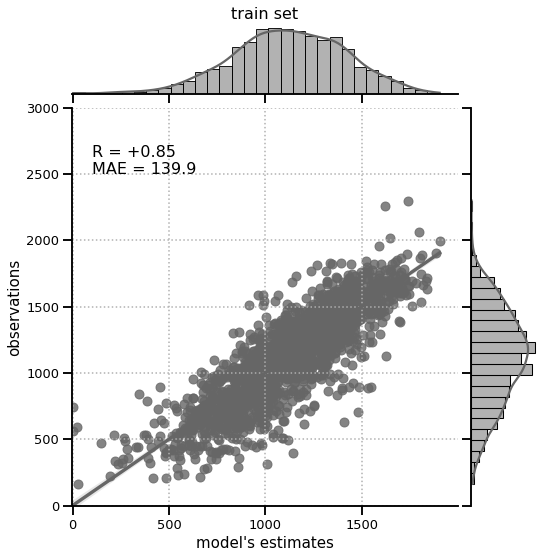

In [144]:
utils.plot_joint_plot(verif.loc[:'2017',:], title='train set', fname='train_set_joint_plot_climate')

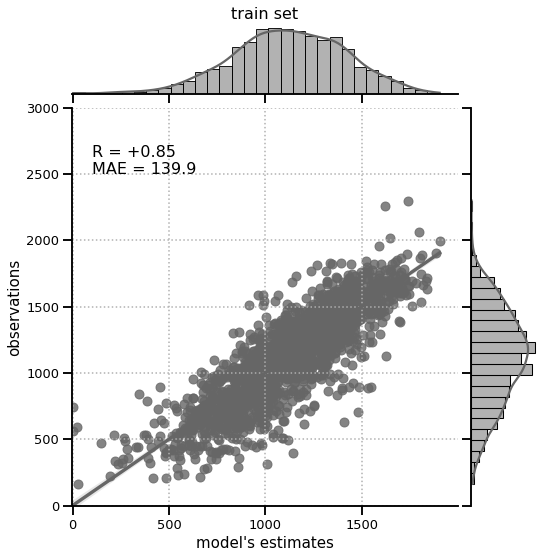

In [144]:
utils.plot_joint_plot(verif.loc[:'2017',:], title='train set', fname='train_set_joint_plot_climate')

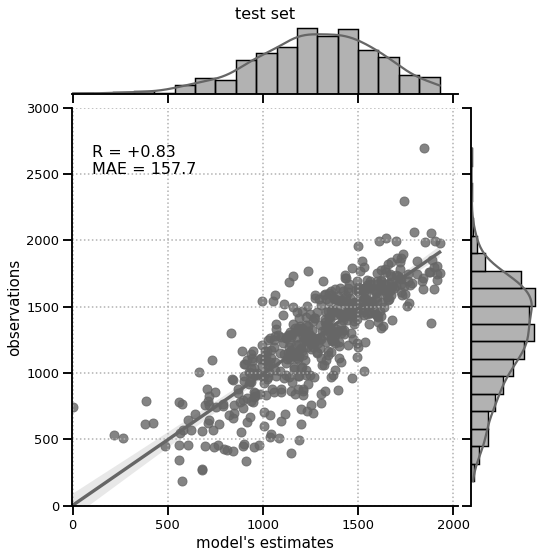

In [145]:
utils.plot_joint_plot(verif.loc['2017':,:], title='test set', fname='test_set_joint_plot_climate')

In [146]:
residuals = verif.loc['2017':,'yhat'] - verif.loc['2017':,'y']

In [146]:
residuals = verif.loc['2017':,'yhat'] - verif.loc['2017':,'y']

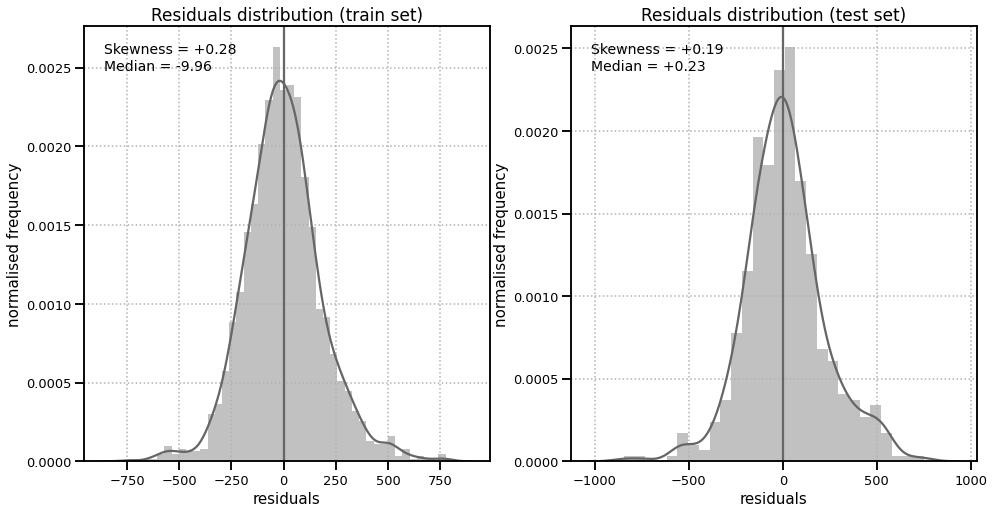

In [147]:
f, axes = plt.subplots(ncols = 2, figsize=(16,8))

ax = axes[0]

sns.distplot((verif.loc[:'2017','yhat'] - verif.loc[:'2017','y']), ax=ax, color='0.4')
ax.grid(ls=':')
ax.set_xlabel('residuals', fontsize=15)
ax.set_ylabel("normalised frequency", fontsize=15)
ax.grid(ls=':')

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

skewness = skew(verif.loc[:'2017','yhat'] - verif.loc[:'2017','y'])
medianres = (verif.loc[:'2017','yhat'] - verif.loc[:'2017','y']).median()

ax.text(0.05, 0.9, "Skewness = {:+4.2f}\nMedian = {:+4.2f}".\
        format(skewness, medianres), \
        fontsize=14, transform=ax.transAxes)

ax.axvline(0, color='0.4')

ax.set_title('Residuals distribution (train set)', fontsize=17)

ax = axes[1]
sns.distplot((verif.loc['2017':,'yhat'] - verif.loc['2017':,'y']), ax=ax, color='0.4')
ax.grid(ls=':')
ax.set_xlabel('residuals', fontsize=15)
ax.set_ylabel("normalised frequency", fontsize=15)
ax.grid(ls=':')

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

ax.text(0.05, 0.9, "Skewness = {:+4.2f}\nMedian = {:+4.2f}".\
        format(skew(verif.loc['2017':,'yhat'] - verif.loc['2017':,'y']), (verif.loc['2017':,'yhat'] - verif.loc['2017':,'y']).median()), \
        fontsize=14, transform=ax.transAxes)

ax.axvline(0, color='0.4')

ax.set_title('Residuals distribution (test set)', fontsize=17)

for ext in ['png','jpeg','pdf']: 
    f.savefig(f'../figures/paper/residuals_distribution_train_test_set_climate.{ext}', dpi=200)

In [148]:
def make_plot_block(verif, start_date, end_date, ax=None, forecast=True, ylim=[100, 2400]): 
    
    df = verif.loc[start_date:end_date,:]
    
    if forecast: 
        df.loc[:,'yhat'].plot(lw=2, ax=ax, color='r', ls='-', label='estimates') 
        ax.fill_between(df.index, df.loc[:,'yhat_lower'], df.loc[:,'yhat_upper'], color='coral', alpha=0.3)
    
    df.loc[:,'y'].plot(lw=2, ax=ax, color='steelblue', ls='-', label='observations')

    ax.grid(ls=':')
    ax.legend(fontsize=15, frameon=False)
    [l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
    [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]
    ax.set_ylabel('cyclists number', fontsize=15)
    ax.set_xlabel('', fontsize=15)
    
    ax.set_ylim(ylim)

    ax.set_title(f'{start_date} to {end_date}', fontsize=18)

In [148]:
def make_plot_block(verif, start_date, end_date, ax=None, forecast=True, ylim=[100, 2400]): 
    
    df = verif.loc[start_date:end_date,:]
    
    if forecast: 
        df.loc[:,'yhat'].plot(lw=2, ax=ax, color='r', ls='-', label='estimates') 
        ax.fill_between(df.index, df.loc[:,'yhat_lower'], df.loc[:,'yhat_upper'], color='coral', alpha=0.3)
    
    df.loc[:,'y'].plot(lw=2, ax=ax, color='steelblue', ls='-', label='observations')

    ax.grid(ls=':')
    ax.legend(fontsize=15, frameon=False)
    [l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
    [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]
    ax.set_ylabel('cyclists number', fontsize=15)
    ax.set_xlabel('', fontsize=15)
    
    ax.set_ylim(ylim)

    ax.set_title(f'{start_date} to {end_date}', fontsize=18)

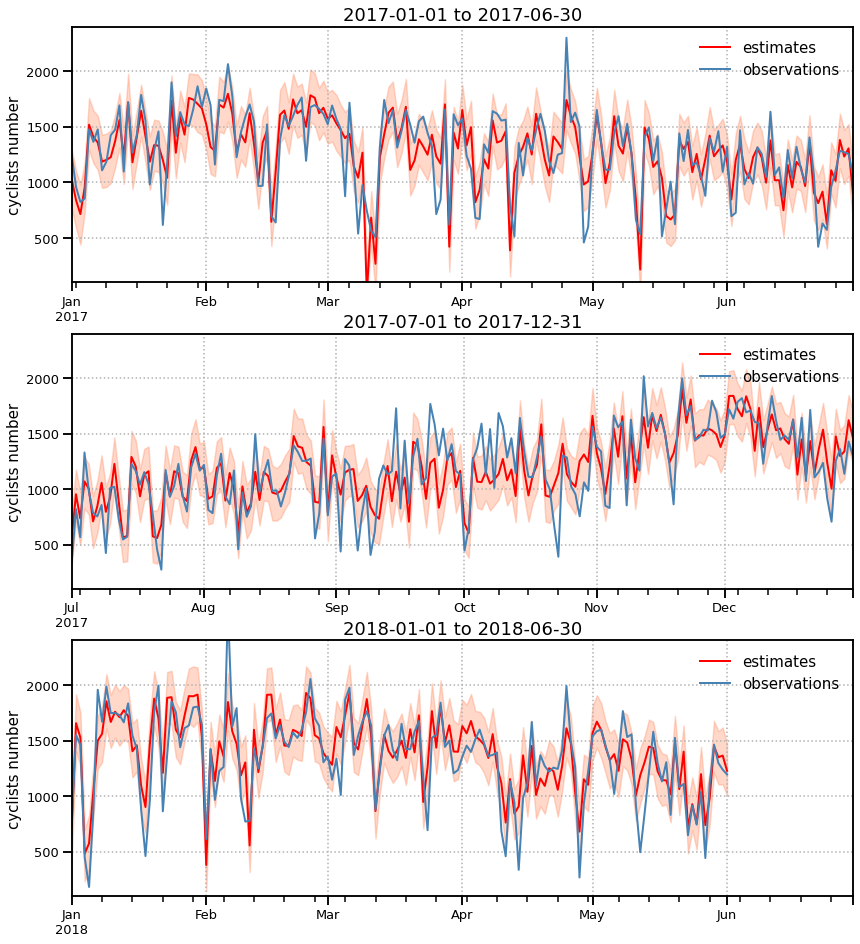

In [149]:
f, axes = plt.subplots(nrows=3, figsize=(14,16), sharey=True)

ax = axes[0]

make_plot_block(verif, '2017-01-01', '2017-06-30', ax=ax, forecast=True)

ax = axes[1]

make_plot_block(verif, '2017-07-01', '2017-12-31', ax=ax, forecast=True)

ax = axes[2]

make_plot_block(verif, '2018-01-01', '2018-06-30', ax=ax, forecast=True)

ax.set_xlim(['2018-01-01','2018-06-30'])

for ext in ['png','jpeg','pdf']: 
    f.savefig('../figures/paper/forecasts_obs_2017-08_forecast.{}'.format(ext), dpi=200)

In [150]:
corr = verif.loc[:,['y','yhat']].rolling(window=90, center=True).corr().iloc[0::2,1]

In [150]:
corr = verif.loc[:,['y','yhat']].rolling(window=90, center=True).corr().iloc[0::2,1]

In [151]:
corr.index = corr.index.droplevel(1)

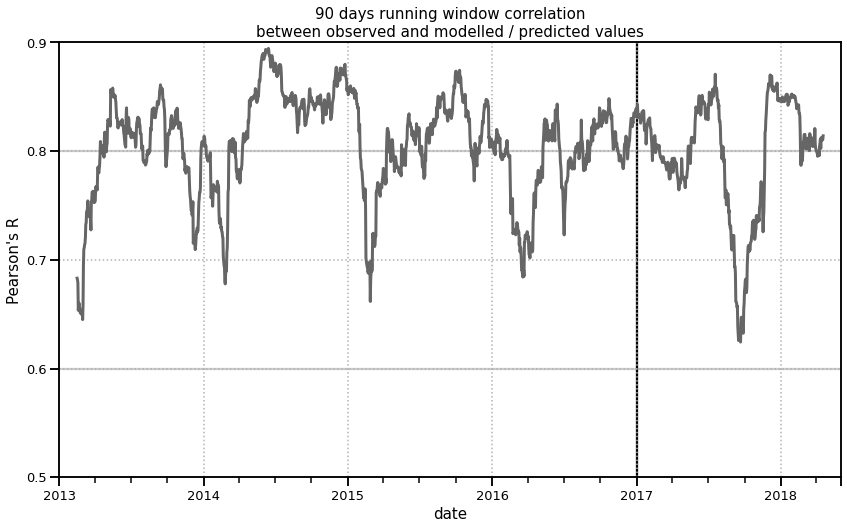

In [152]:
f, ax = plt.subplots(figsize=(14, 8))

corr.plot(ax=ax, lw=3, color='0.4')

ax.axhline(0.8, color='0.8', zorder=-1)
ax.axhline(0.6, color='0.8', zorder=-1)
ax.axvline('2017', color='k', zorder=-1)
ax.grid(ls=':')
ax.set_ylim([0.5, 0.9])
ax.set_xlabel('date', fontsize=15)
ax.set_ylabel("Pearson's R", fontsize=15)
ax.grid(ls=':')
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_yticks(np.arange(0.5, 1., 0.1)); 

ax.set_title('90 days running window correlation\nbetween observed and modelled / predicted values', fontsize=15)

for ext in ['png','jpeg','pdf']: 
    f.savefig(f'../figures/paper/moving_corr.{ext}', dpi=200)

In [153]:
corr_season_test = verif.loc['2017':,['y','yhat']].groupby(verif.loc['2017':,:].index.month).corr()
corr_season_train = verif.loc[:'2017',['y','yhat']].groupby(verif.loc[:'2017',:].index.month).corr()
corr_season = verif.loc[:,['y','yhat']].groupby(verif.loc[:,:].index.month).corr()

In [153]:
corr_season_test = verif.loc['2017':,['y','yhat']].groupby(verif.loc['2017':,:].index.month).corr()
corr_season_train = verif.loc[:'2017',['y','yhat']].groupby(verif.loc[:'2017',:].index.month).corr()
corr_season = verif.loc[:,['y','yhat']].groupby(verif.loc[:,:].index.month).corr()

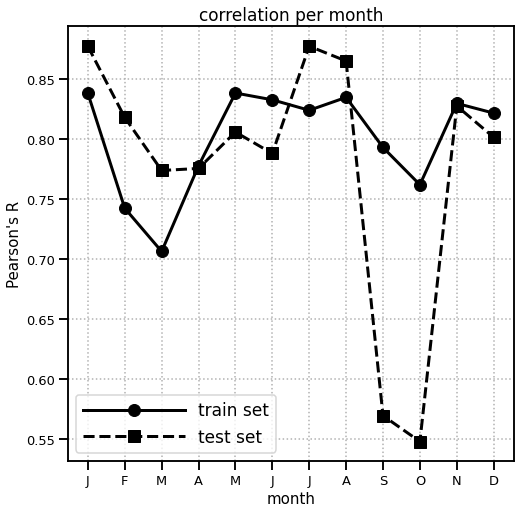

In [154]:
f, ax = plt.subplots(figsize=(8,8))
corr_season_train.xs('y', axis=0, level=1)['yhat'].plot(ax=ax, lw=3, marker='o', markersize=12, label='train set', ls='-', color='k')
corr_season_test.xs('y', axis=0, level=1)['yhat'].plot(ax=ax, lw=3, marker='s', markersize=12, label='test set', ls='--', color='k')
# corr_season.xs('y', axis=0, level=1)['yhat'].plot(ax=ax, lw=3, marker='o', markersize=12)

ax.legend(fontsize=17, loc=3, handlelength=6)

ax.set_xticks(range(1, 13))
ax.set_xticklabels(list('JFMAMJJASOND'))
ax.set_xlabel('month', fontsize=15)
ax.set_ylabel("Pearson's R", fontsize=15)
ax.grid(ls=':')
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_title('correlation per month', fontsize=17)

for ext in ['png','jpeg','pdf']: 
    f.savefig(f'../figures/paper/correlation_obs_pred_per_month.{ext}', dpi=200)

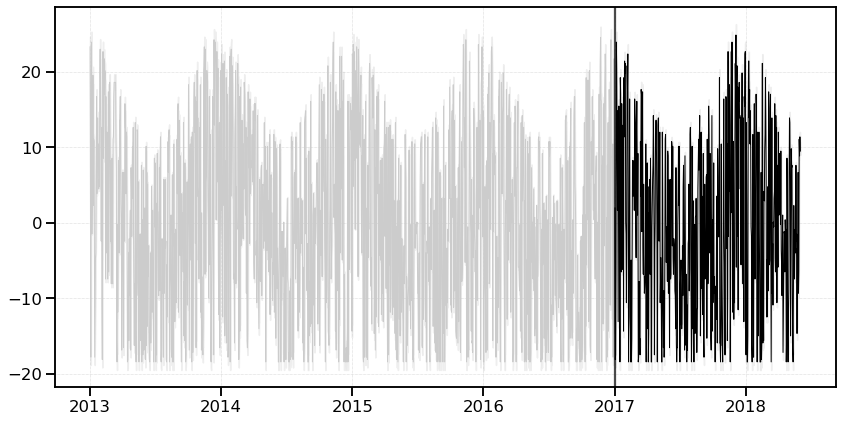

In [155]:
f  = utils.plot_verif_component(verif, component = 'sun')

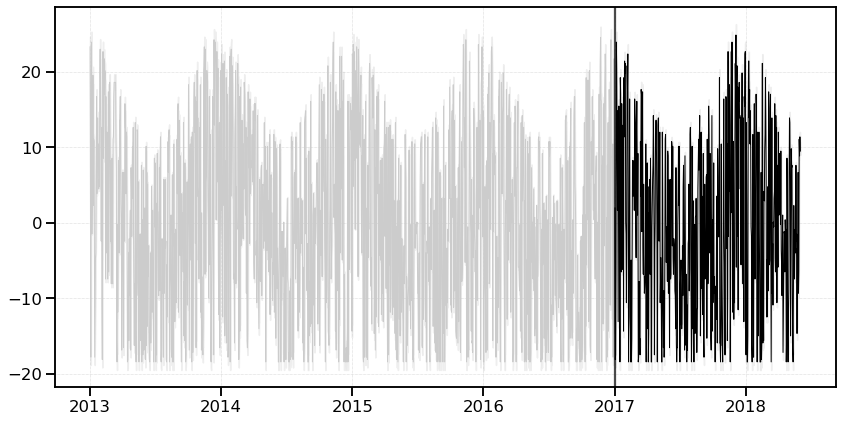

In [155]:
f  = utils.plot_verif_component(verif, component = 'sun')

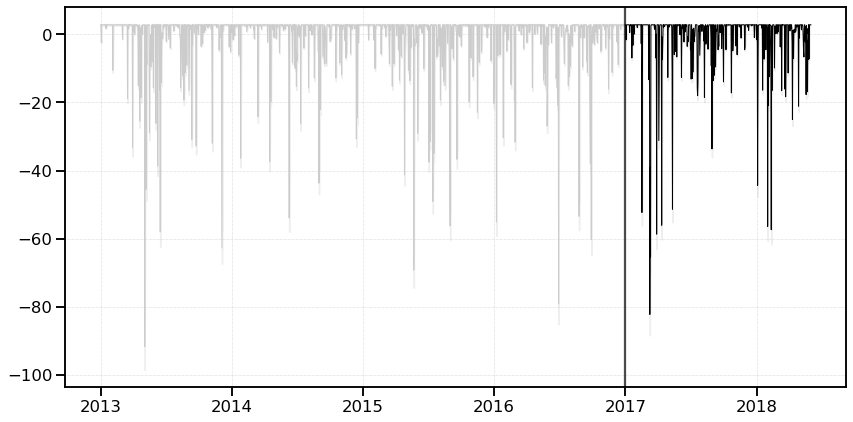

In [156]:
f  = utils.plot_verif_component(verif, component = 'rain')

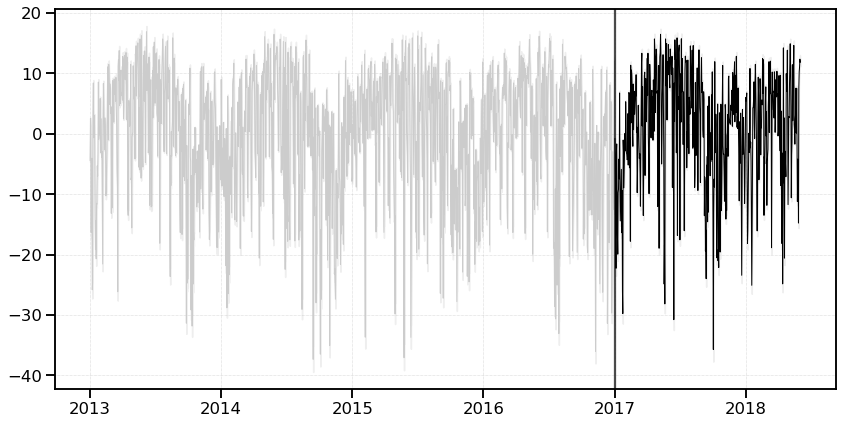

In [157]:
f  = utils.plot_verif_component(verif, component = 'wind')

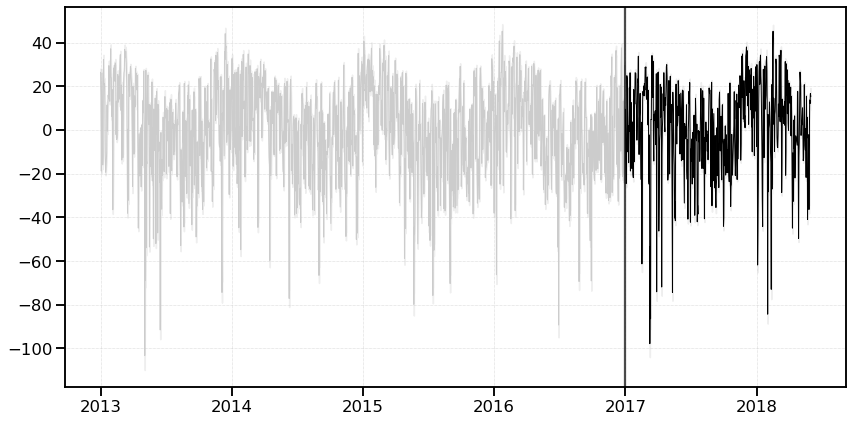

In [158]:
f = utils.plot_verif_component(verif, component = 'extra_regressors_multiplicative')